## Question 5
### Note: 
I installed tensorflow with `conda install tensorflow` and keras with `conda install keras` command. I tried using XGBoost for couple times but I did not get good results with default parameters. I tried to optimize hyperparameters but kernel was stuck and did not lead me to any result after overnight wait. So I decided to use CNN model instead. I had problem using CNN as well. My kernel kept dying but I was able to save pkl file and load the results. I still could not plot heatmap for confusion matrix.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Flatten, Conv2D, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
mnist_csv = np.genfromtxt("mnist_data.csv", delimiter=",")

In [3]:
X = mnist_csv[:, :-1]
y = mnist_csv[:, -1]

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

# Convolution Neural Network:

The idea of CNN model is that it does a mathematical operation with the help of kernel or fitler to build a feature map, then passing through pooling, fully connected layers and then applying softmax function to classify an object.<br>
Initially I decided to put two 2D convolution layers(2D becuase the images are grey and not colored) because single layers are usually used in case of very simple problems which present linearly seperable functions. Multilayer neurons are used to represent convex regions. This means that they can learn to draw shapes around examples in some high-dimensional space that can separate and classify them, overcoming the limitation of linear separability.<br>
I ran first model with few default values without tuning any hyperparameters to get the hang of a model and to check how it performs.

## Preprocessing:
The images we have are of size 28*28 and they need to be flattened to be passed through the convolution layer. We reshape the images as follows. The last number 1 represents the color code grayscale.

In [4]:
X_train = X_train.reshape(21000,28,28,1)
X_test = X_test.reshape(14000,28,28,1)

In [8]:
X_train.shape

(21000, 28, 28, 1)

Data normalization ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

In [5]:
X_train = X_train/255
X_test = X_test/255

Problem with label encoding is that it assumes higher the categorical value, better the category. Machine learning algorithms cannot work with categorical data directly hence using one-hot encoding, we convert the categorical data into a vector of numbers. Also I decided to use [categorical_entropy](https://keras.io/losses/) as a loss function which requires target being categorical format. 

In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
y_train.shape

(21000, 10)

In [9]:
X_next, X_valid, y_next, y_valid = train_test_split(X_train, y_train, test_size=0.1)

## MODEL DESIGN:

### Some of the parameters I decided to look up and tune:<br>

**Kernal/Filter size:**<br>
We can use large or small filter matrix. Since what differentiates our image are small local features like curves, corners, I decided to use 5*5 size for filter.

**Filters**:<br>
In CNNs, filters are not defined. The value of each filter is learned during the training process. the filters are more like feature detectors. I decided to start by using smaller filters 10 to collect as much local information as possible, and then gradually increase the filter width to 32 to represent more global, high-level and representative information. 

**Activation function(Relu):**<br>
The purpose of applying the rectifier function is to increase the non-linearity in our images. The reason we want to do that is that images are naturally non-linear.

**Stride:**<br>
The number of pixels by which we slide the kernel filter is known as the stride. The default value is (1,1).

**Padding:**<br>
When the fitler moves over an image with the specified stirde length (not being one), to fit in the kernel at the edges of the image we have to provide padding. Padding is generally used to add columns and rows of zeroes to keep the spatial sizes constant after convolution, doing this might improve performance as it retains the information at the borders. The input `same` is used for same output size as the input size.

**Max_pool:**<br>
Max_pool down-sample an input representation reducing its dimensionality by keeping the max value(activated features). The idea is to reduce the dimensionality of each feature map but retain the most important information. It also The most common stride length is 2*2.

**Flatten:**<br>
After pooling, the feature learning has been completed. Now we come to flattening. Here the matrix is converted into a linear array to input it into the nodes of our neural network.

**Dense:**<br>
The last Dense value represents the number of classes we have which is 10.


**Dropout:**<br>
Dropout is an approach to regularization in neural networks which avoides overfitting and helps reducing interdependent learning amongst the neurons by **randomly dropping neurons**. Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons. Usually 20% to 50% is standard rate. So I decided to go with 0.5.

**Epoch, Batch_size and Iterations:**<br>
An epoch is a number of times a dataset is passed forward and backward through a neural network once. Since the network learns as the data passes through by upating the weights, we need to pass the dataset multiple times.<br>
A batch size is basically splitting the data in batches and passing the batch at a time and iterations is the number of batches needed to complete one epoch. <br>
There is no specific value for these parameters. Its more of trial and error method. So I chose to go with 20 epochs, 100 batch size to start.

In [15]:
my_model = Sequential()

my_model.add(Conv2D(filters = 10, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
my_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

my_model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))

my_model.add(Dropout(0.5))

my_model.add(Flatten())
my_model.add(Dense(1000, activation = "relu"))
my_model.add(Dropout(0.5))
my_model.add(Dense(10, activation = "softmax"))

my_model.compile(optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),\
                 metrics= ['accuracy'], loss = 'categorical_crossentropy')
history = my_model.fit(X_next,y_next,batch_size=100,\
                           epochs=20,verbose=1,validation_data=(X_valid, y_valid))

Train on 18900 samples, validate on 2100 samples
Epoch 1/20
18900/18900 [==============================] - 56s 3ms/step - loss: 0.3198 - acc: 0.9000 - val_loss: 0.1009 - val_acc: 0.9681
Epoch 2/20
18900/18900 [==============================] - 59s 3ms/step - loss: 0.1025 - acc: 0.9683 - val_loss: 0.0795 - val_acc: 0.9767
Epoch 3/20
18900/18900 [==============================] - 63s 3ms/step - loss: 0.0714 - acc: 0.9770 - val_loss: 0.0639 - val_acc: 0.9776
Epoch 4/20
18900/18900 [==============================] - 65s 3ms/step - loss: 0.0532 - acc: 0.9853 - val_loss: 0.0682 - val_acc: 0.9790
Epoch 5/20
18900/18900 [==============================] - 71s 4ms/step - loss: 0.0476 - acc: 0.9857 - val_loss: 0.0620 - val_acc: 0.9786
Epoch 6/20
18900/18900 [==============================] - 74s 4ms/step - loss: 0.0382 - acc: 0.9876 - val_loss: 0.0722 - val_acc: 0.9805
Epoch 7/20
18900/18900 [==============================] - 63s 3ms/step - loss: 0.0327 - acc: 0.9893 - val_loss: 0.0537 - val_acc:

After looking at several optimizer perormances [here](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) I decided to choose **Adam optimizer** with default parameters from [keras](https://keras.io/optimizers/). Also accuracy is the **metrics** I decided to choose for model evaluation and **categorical_cross entropy** since we have 10 classes.

In [16]:
test_result = my_model.evaluate(X_test,y_test, verbose = 1)

14000/14000 [==============================] - 9s 615us/step


In [17]:
test_result

[0.051355093878506786, 0.9874285714285714]

In [8]:
CNN_model = joblib.load('CNN_model.pkl')
history = joblib.load('model_results.pkl')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

In [11]:
d = {'Accuracy':accuracy, 'loss':loss,'validation_accuracy':val_accuracy,'validation_loss':val_loss}
result = pd.DataFrame(data = d, index = epochs)

In [12]:
result

,Accuracy,loss,validation_accuracy,validation_loss
0,0.900000,0.319812,0.968095,0.100874
1,0.968254,0.102535,0.976667,0.079539
2,0.976984,0.071425,0.977619,0.063873
3,0.985291,0.053194,0.979048,0.068185
4,0.985714,0.047622,0.978571,0.061969
5,0.987566,0.038250,0.980476,0.072162
6,0.989312,0.032707,0.985238,0.053688
7,0.990106,0.029980,0.980952,0.064691
8,0.991481,0.025850,0.980952,0.068874
9,0.992222,0.024579,0.983810,0.060090


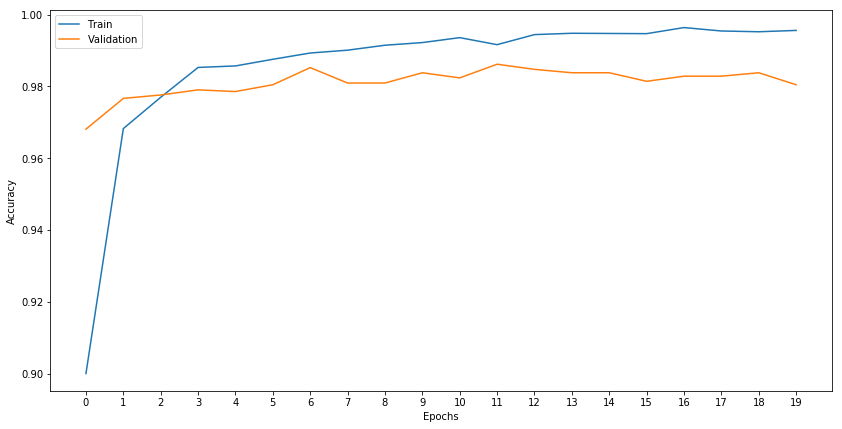

In [21]:
plt.figure(figsize = (14,7))
plt.plot(result['Accuracy'], label = 'Train')
plt.plot(result['validation_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs);

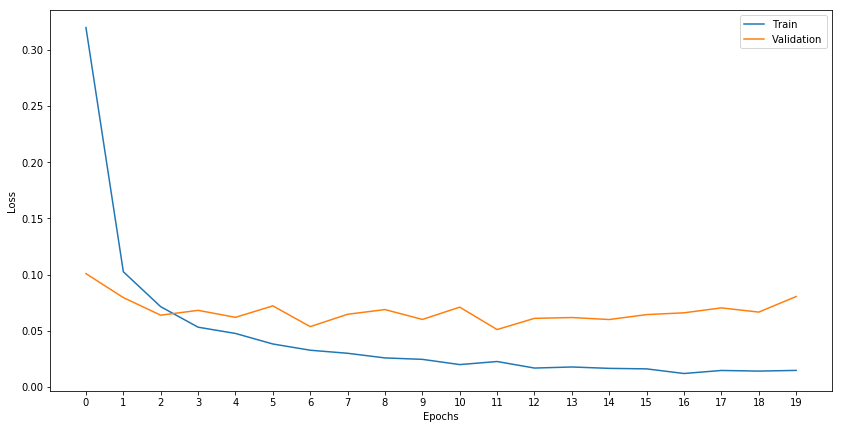

In [29]:
plt.figure(figsize = (14,7))
plt.plot(result['loss'], label = 'Train')
plt.plot(result['validation_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs);

In [9]:
y_predict = CNN_model.predict(X_test)

In [10]:
'''
Converting the predictions to the classes and test set back to classes 
'''
y_classes = np.argmax(y_predict,axis = 1)
y_test = np.argmax(y_test,axis = 1)

In [11]:
dataframe =pd.crosstab(y_test, y_classes, rownames=['Actual'], colnames=['Predicted'], margins=True)
dataframe

Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,1378,2,1,0,0,0,0,0,1,0,1382
1,0,1539,0,0,0,0,0,3,2,1,1545
2,0,0,1381,0,1,0,0,1,2,3,1388
3,0,1,1,1428,0,3,0,2,3,1,1439
4,0,0,0,0,1368,0,3,0,0,1,1372
5,0,0,0,0,0,1285,0,0,1,0,1286
6,3,0,0,0,2,3,1369,0,0,0,1377
7,1,1,8,0,1,0,0,1464,3,3,1481
8,1,1,0,2,1,2,1,0,1346,4,1358


In [12]:
print ('\n*Classification Report:\n', classification_report(y_test, y_classes))


*Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1382
           1       1.00      1.00      1.00      1545
           2       0.99      0.99      0.99      1388
           3       1.00      0.99      1.00      1439
           4       0.99      1.00      0.99      1372
           5       0.99      1.00      1.00      1286
           6       1.00      0.99      1.00      1377
           7       0.99      0.99      0.99      1481
           8       0.99      0.99      0.99      1358
           9       0.99      0.99      0.99      1372

   micro avg       0.99      0.99      0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



## Results:
The accuracy for test result was 98%. The model performed really well for predicting the images without even tuning hyperparameters much. The accuracy and loss per epoch stayed pretty consistent for train and validation set. As we can see in the classification report, model was very strong at predicting pretty much all the classes. 